# Tutorial for Large FOV Instruments

In this tutorial we will learn how to get the 10%, 50% and 90% credible regions. We will then use this to find the best pointing possible for a telescope with a circular FOV.

We begin by importing the necessary packages.

In [1]:
# -- For Google Colab
#! pip install -q astropy astroquery healpy matplotlib scipy 

import healpy as hp # for working with HEALPix files
import numpy as np # needed for vector operations
from matplotlib import pyplot as plt # plotting skymaps

In [2]:
from astropy.utils.data import download_file
url = ('https://dcc.ligo.org/public/0146/G1701985/001/LALInference_v2.fits.gz')
# This is the publication LALInference localization
filename = download_file(url, cache=True)

In [3]:
prob = hp.read_map(filename)

Now we find the credible levels.

In [4]:
i = np.flipud(np.argsort(prob)) # Array of pixel indices ordered from highest to lowest probability densities
cumsum = np.cumsum(prob[i]) # Array of the cumulative sums of the ordered probability density pixels
cls = np.empty_like(prob) # A new array with the same shape and type as prob
cls[i] = cumsum*100 # The new array filled in with the value of the cumulative sums by the time we reach that pixel index

Now we will attempt to plot the 10%, 50%, and 90% credibility regions

In [5]:
# Creating three arrays with the same shape/type as prob
region10 = np.empty_like(prob)
region50 = np.empty_like(prob)
region90 = np.empty_like(prob)

for i in range(len(prob)):
    
    if cls[i] <= 90:
        region90[i] = 1    
    else:
        region90[i] = 0
    
    if cls[i] <= 50:
        region50[i] = 1
    else:
        region50[i]  = 0    
    
    if cls[i] <= 10:
        region10[i] = 1
    else:
        region10[i] = 0

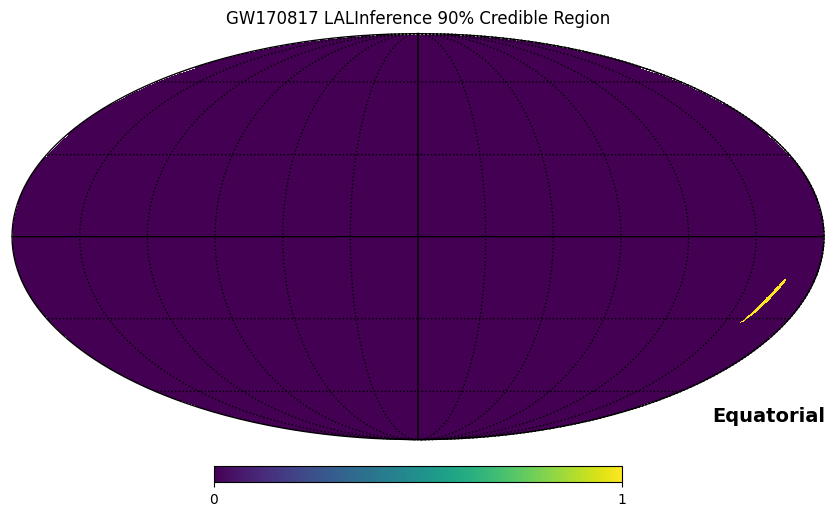

<Figure size 640x480 with 0 Axes>

In [6]:
hp.mollview(region90, coord=['C'], title='GW170817 LALInference 90% Credible Region', hold=False)
hp.graticule(local=True)
plt.figure(frameon=False)
plt.show()

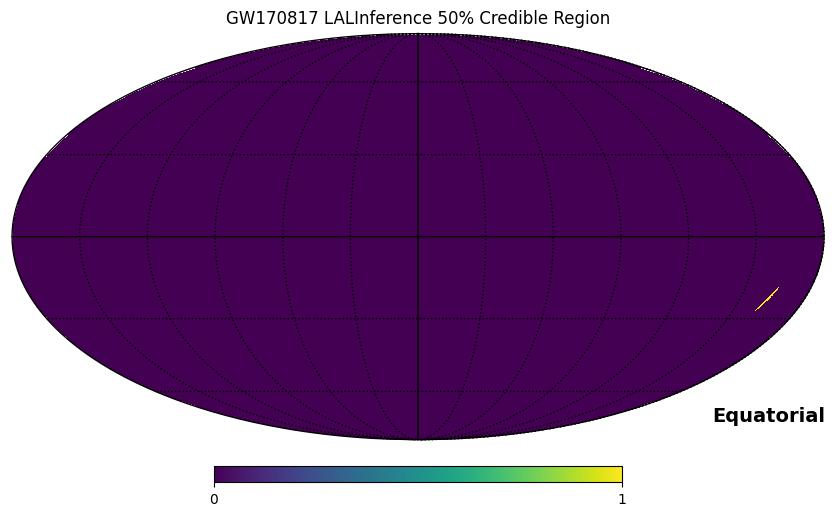

<Figure size 640x480 with 0 Axes>

In [7]:
hp.mollview(region50, coord=['C'], title='GW170817 LALInference 50% Credible Region', hold=False)
hp.graticule(local=True)
plt.figure(frameon=False)
plt.show()

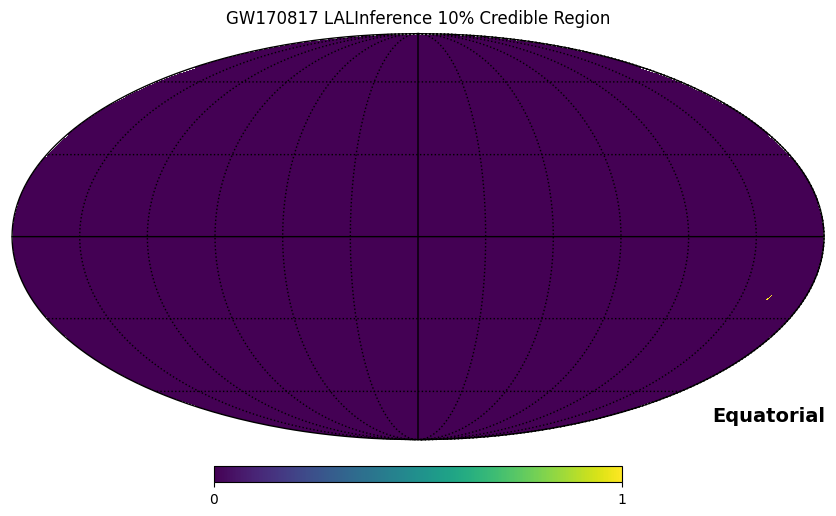

<Figure size 640x480 with 0 Axes>

In [8]:
hp.mollview(region10, coord=['C'], title='GW170817 LALInference 10% Credible Region', hold=False)
hp.graticule(local=True)
plt.figure(frameon=False)
plt.show()

# Finding the best pointing

Now, we will attempt to find the best pointing for a circular FOV instrument.

Let us use the Dark Energy Camera (DECam), which has a 3 deg$^2$ FOV as our example.

In [9]:
fov = 3 # FOV in degrees^2
r = np.sqrt(3/np.pi) # The "radius" in degrees
r = np.sqrt(3*np.pi) # The "radius" converted into radians
dp_limit = np.cos(r) # The dot product limit that will determine whether a pixel is within the FOV or not

Because our resolution is too high for this tutorial, we will downgrade the resolution of the map so that it will run in a timely manner.

In [10]:
simple_prob = hp.ud_grade(prob, nside_out=32)

In [11]:
maxpix = np.argmax(simple_prob)
maxpixProb = simple_prob[maxpix] # Probability contained in maxpix
nside = hp.get_nside(simple_prob)
npix = len(simple_prob)
best_centerpix = None
best_fovprob = 0

for i in range(npix):
    if simple_prob[i] >= 0.01*maxpixProb:
        centerpixcoord = hp.pix2ang(nside, i)
        fovprob = 0
        for j in range(npix):
            jpixcoord = hp.pix2ang(nside, j)
            if np.dot(centerpixcoord, jpixcoord) >= dp_limit:
                fovprob += simple_prob[j]
            else:
                pass
        if fovprob >= best_fovprob:
            best_centerpix = i
            best_fovprob = fovprob
        else:
            pass
    else:
        pass

best_centerpix, best_fovprob

(9736, 0.0009765624999999991)

Thus, if we point in the direction of the 9736th pixel in the down-sampled pskymap, we would capture the most probability.